In [5]:

import pathlib
import sys
import numpy as np
from PIL import Image
import gymnasium
from gymnasium.core import Env
from gymnasium.envs.mujoco.mujoco_rendering import MujocoRenderer
from metaworld.envs import ALL_V2_ENVIRONMENTS_GOAL_OBSERVABLE
import matplotlib.pyplot as plt
import cv2
import os
import copy
import imageio
from IPython import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 
import warnings
warnings.filterwarnings("ignore", ".*")
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
from IPython.display import HTML

# HTML 代码
html_code = """
<div style="display: flex; justify-content: space-between; align-items: center;">
    <div style="text-align: center;">
        <img src="assets/metaworld-button-press-rotation-strong.gif" alt="Image 1" style="width: 400px; height: auto;">
        <p>Rotation</p>
    </div>
    <div style="text-align: center;">
        <img src="assets/metaworld-button-press-shake-strong.gif" alt="Image 2" style="width: 400px; height: auto;">
        <p>Shake</p>
    </div>
    <div style="text-align: center;">
        <img src="assets/metaworld-button-press-translation-strong.gif" alt="Image 3" style="width: 400px; height: auto;">
        <p>Translation</p>
    </div>
    <div style="text-align: center;">
        <img src="assets/metaworld-button-press-zoom-strong.gif" alt="Image 4" style="width: 400px; height: auto;">
        <p>Zoom</p>
    </div>
</div>
"""

# 渲染 HTML
HTML(html_code)

## Camera Wrappers

In [62]:
DEFAULT_CAMERA_CONFIG = {
    "distance": 1.25,
    "azimuth": 145,
    "elevation": -25.0,
    "lookat": np.array([0.0, 0.65, 0.0]),
    }

class MetaWorldMovableCameraWrapper(gymnasium.Wrapper):
    def __init__(self, env: Env, seed:int, size=224, viewpoint_mode='controlled', viewpoint_randomization_type='weak'):
        super().__init__(env)

        ##################################################################################
        '''
        controlled mode: the viewpoint is controlled by a sensory policy, smoothly changes in a valid range;
        '''
        self.viewpoint_mode = viewpoint_mode
        self.viewpoint_randomization_type = viewpoint_randomization_type
        assert self.viewpoint_randomization_type in ['weak', 'medium', 'strong'], viewpoint_randomization_type
        assert self.viewpoint_mode in ['controlled', 'shake', 'rotation', 'translation', 'zoom'], viewpoint_mode
        self.init_camera_config = {
            "distance": 1.25,
            "azimuth": 145,
            "elevation": -25.0,
            "lookat": np.array([0.0, 0.65, 0.0]),
            }
        self.curr_camera_config = {
            "distance": 1.25,
            "azimuth": 145,
            "elevation": -25.0,
            "lookat": np.array([0.0, 0.65, 0.0]),
            }
        self.camera_range_config = {
            "distance_min": 0.50,
            "distance_max": 2.50,
            "azimuth_min": 115,
            "azimuth_max": 175,
            "elevation_min": -85.0,
            "elevation_max": -5.0,
            "lookat_min": np.array([0.0, 0.15, 0.0]),
            "lookat_max": np.array([0.8, 1.00, 0.8]),
            }
        self.viewpoint_step = 0
        self.viewpoint_period = 100
        if self.viewpoint_mode == 'controlled':
            self.camera_unit_config = {
                "distance": (self.camera_range_config['distance_max'] - self.camera_range_config['distance_min']) / 10,
                "azimuth": (self.camera_range_config['azimuth_max'] - self.camera_range_config['azimuth_min']) / 10,
                "elevation": (self.camera_range_config['elevation_max'] - self.camera_range_config['elevation_min']) / 10,
                "lookat": (self.camera_range_config['lookat_max'] - self.camera_range_config['lookat_min']) / 10,
                }
            
        ##################################################################################

        self.size = size
        self.unwrapped.model.vis.global_.offwidth = size
        self.unwrapped.model.vis.global_.offheight = size
        
        # Hack: enable random reset
        self.unwrapped._freeze_rand_vec = False
        self.unwrapped.seed(seed)

    def reset(self):
        ##################################################################################
        for k, v in self.curr_camera_config.items():
            self.curr_camera_config[k] = self.init_camera_config[k]
        self.viewpoint_step = 0
        ##################################################################################
        obs, info = super().reset()
        
        return obs, info

    def step(self, action):
        next_obs, reward, done, truncate, info = self.env.step(action) 
        
        return next_obs, reward, done, truncate, info
        
    def render(self, camera_config=None, sensory_action=None):
        if camera_config == None:
            if self.viewpoint_mode == 'controlled':
                assert sensory_action is not None
                for i, k in enumerate(self.curr_camera_config.keys()):
                    self.curr_camera_config[k] += sensory_action[i] * self.camera_unit_config[k]
            elif self.viewpoint_mode == 'rotation':
                self.viewpoint_rotation = dict(weak=[135, 155], medium=[125, 165], strong=[115, 175])[self.viewpoint_randomization_type]
                self.curr_camera_config['azimuth'] = self.init_camera_config['azimuth'] + \
                        np.sin( self.viewpoint_step / self.viewpoint_period * 2 * np.pi) * \
                              (self.viewpoint_rotation[1] - self.viewpoint_rotation[0])
                for i, k in enumerate(self.curr_camera_config.keys()):
                    if k != 'azimuth':
                        self.curr_camera_config[k] = self.init_camera_config[k] + np.random.normal(0.0, (self.camera_range_config[k+'_max'] - self.camera_range_config[k+'_min'])/50)
            elif self.viewpoint_mode == 'shake':
                self.viewpoint_shake = dict(weak=50, medium=25, strong=10)[self.viewpoint_randomization_type]
                for i, k in enumerate(self.curr_camera_config.keys()):
                    self.curr_camera_config[k] = self.init_camera_config[k] + np.random.normal(0.0, (self.camera_range_config[k+'_max'] - self.camera_range_config[k+'_min'])/self.viewpoint_shake)
            elif self.viewpoint_mode == 'translation':
                self.viewpoint_translation = dict(weak=[0.45, 0.80], medium=[0.30, 0.90], strong=[0.15, 1.00])[self.viewpoint_randomization_type]
                self.curr_camera_config['lookat'][1] = self.init_camera_config['lookat'][1] + \
                        np.sin( self.viewpoint_step / self.viewpoint_period * 2 * np.pi) * \
                              (self.viewpoint_translation[1] - self.viewpoint_translation[0])
                for i, (k, v) in enumerate(self.curr_camera_config.items()):
                    if k != 'lookat':
                        self.curr_camera_config[k] = self.init_camera_config[k] + np.random.normal(0.0, (self.camera_range_config[k+'_max'] - self.camera_range_config[k+'_min'])/50)
                    else:
                        for lookat_idx in range(len(v)):
                            if lookat_idx != 1:
                                self.curr_camera_config[k][lookat_idx] = self.init_camera_config[k][lookat_idx] + np.random.normal(0.0, (self.camera_range_config[k+'_max'][lookat_idx] - self.camera_range_config[k+'_min'][lookat_idx])/50)
            elif self.viewpoint_mode == 'zoom':
                self.viewpoint_zoom = dict(weak=[1.0, 1.5], medium=[0.75, 2.0], strong=[0.5, 2.5])[self.viewpoint_randomization_type]
                self.curr_camera_config['distance'] = self.init_camera_config['distance'] + \
                        np.sin( self.viewpoint_step / self.viewpoint_period * 2 * np.pi) * \
                              (self.viewpoint_zoom[1] - self.viewpoint_zoom[0])
                for i, k in enumerate(self.curr_camera_config.keys()):
                    if k != 'distance':
                        self.curr_camera_config[k] = self.init_camera_config[k] + np.random.normal(0.0, (self.camera_range_config[k+'_max'] - self.camera_range_config[k+'_min'])/50)
        else:
            self.curr_camera_config = camera_config
        for k, v in self.curr_camera_config.items():
            self.curr_camera_config[k] = np.clip(self.curr_camera_config[k], self.camera_range_config[k+'_min'], self.camera_range_config[k+'_max'])
        self.viewpoint_step += 1
        self.unwrapped.mujoco_renderer = MujocoRenderer(self.env.model, self.env.data, self.curr_camera_config)
        return self.unwrapped.mujoco_renderer.render(render_mode = "rgb_array")

def setup_metaworld_env(task_name:str, seed:int, size:int, viewpoint_mode:str, viewpoint_randomization_type:str):
    env_cls = ALL_V2_ENVIRONMENTS_GOAL_OBSERVABLE[task_name]
    env = MetaWorldMovableCameraWrapper(env_cls(), seed, size, viewpoint_mode=viewpoint_mode, viewpoint_randomization_type=viewpoint_randomization_type)
    return env



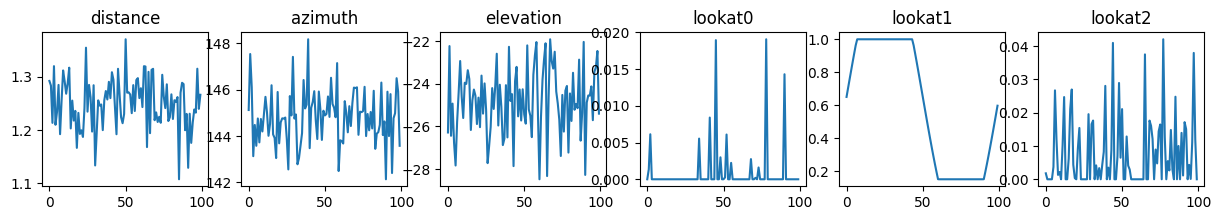

In [64]:
viewpoint_mode, viewpoint_randomization_type = 'translation', 'strong'
env = setup_metaworld_env('button-press-v2-goal-observable', 10, 64, viewpoint_mode, viewpoint_randomization_type)
obs, _ = env.reset()
camera_configs = {
            "distance": [],
            "azimuth": [],
            "elevation": [],
            "lookat0": [],
            "lookat1": [],
            "lookat2": []
            }
T = 100
_ = env.reset()
with imageio.get_writer(uri=f'assets/metaworld-button-press-{viewpoint_mode}-{viewpoint_randomization_type}.gif', mode='I', fps=10) as writer:
    for i in range(T):
        _ = env.step(env.env.action_space.sample())
        img_array = env.render(sensory_action=np.random.uniform(-1, 1, size=6))
        writer.append_data(img_array)
        for k, v in env.curr_camera_config.items():
            if k != 'lookat':
                camera_configs[k].append(v)
            else:
                for lookat_idx in range(len(v)):
                    camera_configs[f"lookat{lookat_idx}"].append(v[lookat_idx])
_ = plt.subplots(1, 6, figsize=(15, 2))
for i, (k, v) in enumerate(camera_configs.items()):
    _ = plt.subplot(1, 6, i+1)
    _ = plt.plot(v)
    _ = plt.title(k)
plt.show()
